#  ADC MS9280
- 10-bit
- 35 MSPS
- sample annd hold amplifier
- single-ended OR differential inputs
- Range selection / offset selection
- Tristate voltage (1, 0, high-Z)

## Examples

### bolt: MSMS9280 
#### Device functionality
- Voltage glitcher (can pull voltages to ground at very high speeds)
- Differential power analysis oscilloscope
- 8-channel logic analyzer (with GPIO's connected directly to RP2040, frequencies up to 200 MHz)

<img src="images/ms9280_bolt.png" width="1000" height="400" />

#### ADC Mode configuration (Top / Bottom)
- AIN: input connection
- Mode pin: AVDD = 3.3 V
- REFSENSE pin: Grounded
- REFTS, VREF: shorted
- REFBS: grounded
- AIN: 2 V (reference voltage 2 V)
#### ADC Input clock
- Generated by an MCO of the RP2040

#### Clamp-pin
- CLAMPIN: unconnected
- CLAMP: grounded

#### REFBF / REFTF
- 0.1 uF for each between GNDA and pin
- 10 uF and 0.1 uF between the 2 lines

### glitching_fmaw: MS9280

<img src="images/ms9280_glitching_fmaw.png" width="1000" height="400" />

### AD9280 Evaluation board
https://download.datasheets.com/pdfs/2010/8/23/1/49/52/396/adi_/manual/ad9280.pdf

<img src="images/ms9280_AD9280.png" width="700" height="400" />

### ADC Mode configuration (Top / Bottom)
- AIN: input connection
- Mode pin: AVDD (3.3 V)
- REFSENSE pin (Grounded)
- REFTS, VREF: Shorted
- REFBS: grounded
- AIN: 2 V

### Decoupling
#### REFBF / REFTF
- 0.1 uF for each between GNDA and pin
- 10 uF and 0.1 uF between the 2 lines


### Input pin filtering
#### ADC_AIN


## Execution

### ADC Mode choice

Choose the ADC to be in differential-mode by default:
- DC offset circuitry not needed
	- Introduces accuracy errors (exact shift unknown) and noise
- Common mode filtering (cancels out even harmonics)

**Settings**
- AIN -> input 1
- REFTS, REFBS shorted -> input 2
- Mode: AVDD / 2
- REFSENSE: 
	- VREF = 2  (default): [Connect REFSENSE to VREF]
	- VREF = 1  (switch): [Connect REFSENSE to AGND]
- REFTS, REFBS: AVDD / 2

**Default ADC connection is differential-mode, 2 V reference, top/bottom and center conections with 1/2 V reference are possible with jumper connections**

**!IMPORTANT: Make sure when routing to place differential jumpers as closely as possible**

### Decoupling / Filtering capacitors
#### REFTF / REFBF
- Top and bottom reference decoupling pins.


**0.1 uF (GNDA <=> pin), 10 uF, 0.1 uF (REFTF <=> REFBF), see examples + docs**

### ADC Input Clock
- Deliver it from the FPGA / MCU you choose
	- Set appropriately to change different modes
- It requires a 35 MHz signal with sharp edges, so pay attention to traces

**Delivery from FPGA**

### Tristate / STBY
- Should be low by default
- High: high-impedance state (add button)

**Connect to ground through closed jumper**

### OTR
Indicates whether the signal is out of range

**Connect to an FPGA input, and add testpoint**

### Mode
**Connect to Vdd/2 by default, have open soldering bridges for connection Vdd and GND**
- This way we can always decide to change the mode if necessary.

### Clamping

Is simply to force a DC bias on AIN
Not used in our case (can always be done externally as well)
- CLAMPIN: pin with the DC bias voltage to be superposed on AIN
- CLAMP: switches OPAMP output to AIN (imposes bias voltage from CLAMPIN)

![](images/clamp_circuit.png)

**Tie the CLAMP-pin low**
**Tie the CLAMPIN-pin to ground**

### AVSS, DRVSS
Digital and analog ground-

## Input connectors
- Use an RJ45 connector, connect a single pair

### Why we need a differential resistor
- Twisted pair sees 2 DC bias resistors.
- Sees at sampling rates ADC's internal sampling caps of a few pF and ESD diodes.
- This is destined to cause oscillations with the line inductance ($f_0 = \frac{1}{2*\pi*\sqrt(L*C)}$), if not enough damping is applied.
- Placing a differential resistor in parallel with the lines dampens the oscillations.

#### Why don't we use series resistors
- Imbalance between resistors messes up the signal
- More effective damping
- Voltage drop over the series resistor
- Matching with differential tranmission line, which is often 100 ohms.


### Why do we bias both pins
- The 2 inputs need to be connected either through a transformer or a resistor termination.
- In a differential ADC both pins are biased to Vref/2.
	- Since the OPAMP can only handle voltages between 0 and Vref.
	- Later the Vref/2 is then added so you end-up mid-scale

### Options for input stage
#### Baluns + differential resistance option
- We need to add a 1:1 balun in order to isolate the DC bias of the analog front-end from the connector.
- We need to bring both pins onto a Vdd/2 bias level, and we need a differential termination there as well.
- The 100 ohm termination can be connected in parallel with the balun.
	- Balun has a parallel magnetizing inductance, make sure it looks like an open circuit at MHz frequencies.

**It seems the balun-configuration is mostly a configuration type used for higher frequencies**

#### Input caps + differential resistance option
- Simply put 2 DC-blocking caps (33-100nF) in series with the signal
	- Cutoff frequency fc = 1 / (2*pi*50*C) (with 100 ohm differential input impedance)

In [17]:
import math

f_flat = 10e3
r_diff = 100
w_flat = 2*math.pi*f_flat

c_required = 1/(w_flat * r_diff/2)
print(f"Series capacitance {c_required*1e9} nF for f_cutoff {f_flat*1e-6} MHz")

Series capacitance 318.3098861837907 nF for f_cutoff 0.01 MHz


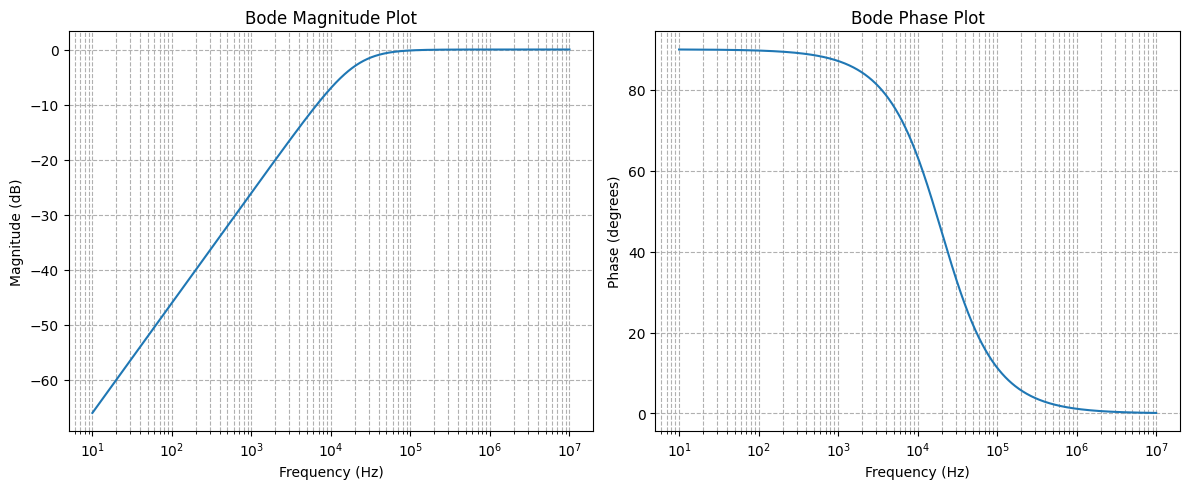

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Component values
R = r_diff / 2 # ohms
C = c_required  # farads

# Frequency sweep
f = np.logspace(1, 7, 1000)
w = 2 * np.pi * f

# Transfer function H(jω)
sRC = 1j * w * R * C
H = sRC / (2 + sRC)

# Magnitude and phase
mag = 20 * np.log10(np.abs(H))
phase = np.angle(H, deg=True)

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Magnitude plot
ax1.semilogx(f, mag)
ax1.set_title('Bode Magnitude Plot')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.grid(True, which='both', linestyle='--')

# Phase plot
ax2.semilogx(f, phase)
ax2.set_title('Bode Phase Plot')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.grid(True, which='both', linestyle='--')

plt.tight_layout()
plt.show()

**So the main issue with having input capacitors is the phase-shift that happens in the frequency range of 100 kHz to 10 MHz, we can however digitize the signal and perform digital phase-shifting. Also if we take larger capacitors we risk being in the inductive region.**

#### 2 resistors to vref / 2 vs single 100 ohm resistor
The ADC schematic indicates a direct connection from AIN- to vref / 2, but it is perhaps better to bias both pins with a 50 ohm resistor separately.



### Shielding
- Make sure there is an extra shielding wire on the outside.

### Sources:
- https://ww1.microchip.com/downloads/aemDocuments/documents/MCU08/ProductDocuments/SupportingCollateral/Differential-and-Single-Ended-ADC-WhitePaper-DS00003197A.pdf

# Preamplifier

## Fully differential amplifier
### Resistor matching
- LT5400A
